# Model Training

### Import necessary libraries

In [83]:
from math import sqrt
from datetime import timedelta, datetime

import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data, _customer_lifetime_value
from lifetimes.plotting import (
    plot_frequency_recency_matrix,
    plot_probability_alive_matrix,
    plot_period_transactions,
)
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Load prepared data from CSV

In [84]:
df = pd.read_csv("../data/ltv_cleaned_data.csv", index_col=0)

df[["event_timestamp", "first_purchase_time", "cohort_week"]] = df[
    ["event_timestamp", "first_purchase_time", "cohort_week"]
].apply(pd.to_datetime)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1200 entries, 0 to 1199
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              1200 non-null   object        
 1   event_timestamp      1200 non-null   datetime64[ns]
 2   first_purchase_time  1200 non-null   datetime64[ns]
 3   cohort_week          1200 non-null   datetime64[ns]
 4   product_id           1200 non-null   object        
 5   lifetime_months      1200 non-null   int64         
 6   price                1200 non-null   float64       
 7   frequency            1200 non-null   int64         
 8   revenue              1200 non-null   float64       
dtypes: datetime64[ns](3), float64(2), int64(2), object(2)
memory usage: 93.8+ KB


## Prepare prediction dataframe

In [85]:
# find_outliers = df["lifetime_months"] < 6
# df = df[find_outliers]
# RMSE:  6.131058669503068 mae:  3.4775814510101237

prediction_df = df.drop(columns=["price", "frequency", "lifetime_months"])

prediction_df.describe()

,event_timestamp,first_purchase_time,cohort_week,revenue
count,1200,1200,1200,1200.000000
mean,2023-05-16 22:08:55.034166528,2023-04-03 23:56:55.034166784,2023-03-30 10:40:48,47.128933
min,2023-03-06 04:55:30,2023-03-06 04:55:30,2023-03-05 00:00:00,12.490000
25%,2023-04-05 11:13:16.500000,2023-03-17 08:11:44,2023-03-12 00:00:00,12.490000
50%,2023-05-02 05:23:36.500000,2023-03-31 09:34:10.500000,2023-03-26 00:00:00,49.960000
75%,2023-06-18 15:04:00.249999872,2023-04-22 06:10:08,2023-04-16 00:00:00,74.940000
max,2023-10-14 06:00:06,2023-05-07 14:00:39,2023-04-30 00:00:00,99.920000
std,NaN,NaN,NaN,30.123443


In the commented code I try to show why didn't I remove outliers from the df. After I've done that and fitter model again, I've got RMSE:  6.131058669503068 and MAE:  3.4775814510101237. That shows really unaccurate results. So I decided to leave them in the dataframe

In [86]:
observation_period_end = str(prediction_df["event_timestamp"].max().date())

observation_period_end

'2023-10-14'

In [87]:
summary_df = summary_data_from_transaction_data(
    prediction_df,
    "user_id",
    "event_timestamp",
    observation_period_end=observation_period_end,
)
summary_df = summary_df.merge(prediction_df, on="user_id")

summary_df.head()

,user_id,frequency,recency,T,event_timestamp,first_purchase_time,cohort_week,product_id,revenue
0,0047993c-3cff-4ab4-a34a-e376f823c282,0.0,0.0,206.0,2023-03-22 06:02:55,2023-03-22 06:02:55,2023-03-19,monthly.12.49,12.49
1,00f7a8b6-9dd5-4806-bc31-69c8bc68bb24,0.0,0.0,180.0,2023-04-17 10:19:29,2023-04-17 10:19:29,2023-04-16,monthly.12.49,12.49
2,0124f243-d4d0-4971-b997-1e6b79c866f0,1.0,30.0,181.0,2023-04-16 15:14:30,2023-04-16 15:14:30,2023-04-09,monthly.12.49,24.98
3,0124f243-d4d0-4971-b997-1e6b79c866f0,1.0,30.0,181.0,2023-05-16 15:14:30,2023-04-16 15:14:30,2023-04-09,monthly.12.49,24.98
4,0126e40c-da09-4e28-b687-457716e6ccfd,0.0,0.0,219.0,2023-03-09 16:54:50,2023-03-09 16:54:50,2023-03-05,monthly.12.49,12.49


## Create prediction model

In [88]:
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(summary_df["frequency"], summary_df["recency"], summary_df["T"])

<lifetimes.BetaGeoFitter: fitted with 1200 subjects, a: 0.00, alpha: 79.96, b: 0.14, r: 1.17>

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

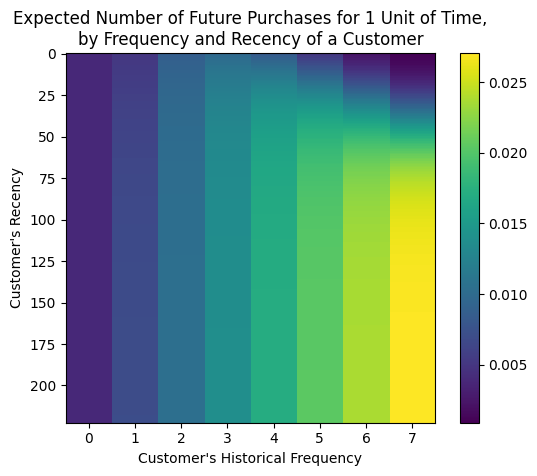

In [89]:
plot_frequency_recency_matrix(bgf)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

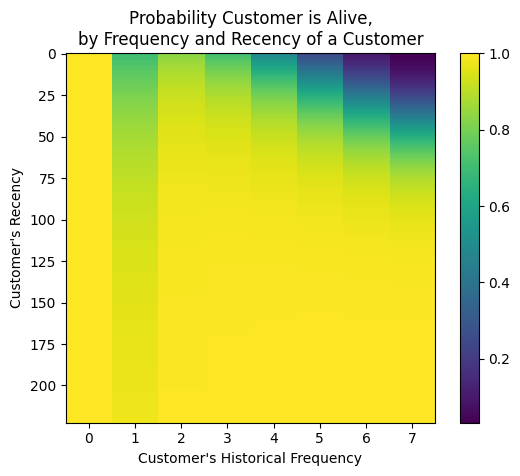

In [90]:
plot_probability_alive_matrix(bgf)

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

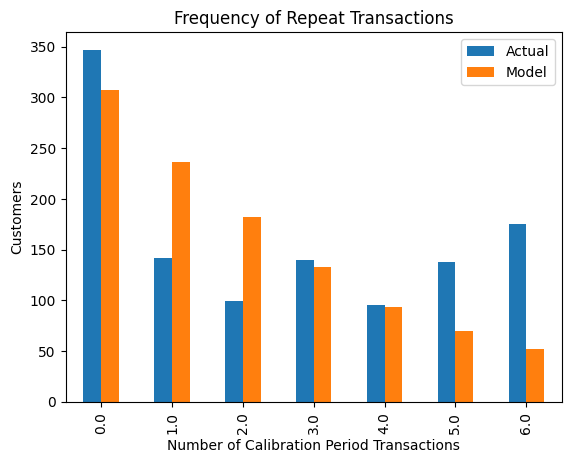

In [91]:
plot_period_transactions(bgf)

### Calculate ltv by user using lifetimes library

In [92]:
_customer_lifetime_value(
    bgf,
    summary_df["frequency"],
    summary_df["recency"],
    summary_df["T"],
    summary_df["revenue"],
    time=12,
    freq="M",
).to_frame().rename(columns={"clv": "ltv"})

,ltv
0,0.576092
1,0.633648
2,2.024288
3,2.024288
4,0.551065
...,...
1195,24.220351
1196,24.220351
1197,24.220351
1198,24.220351


In [93]:
summary_df["prediction_period"] = summary_df["event_timestamp"].min() + timedelta(
    days=365
)

summary_df["rest"] = (
    summary_df["prediction_period"] - summary_df["event_timestamp"]
).dt.days / 30.44

summary_df.describe()

,frequency,recency,T,event_timestamp,first_purchase_time,cohort_week,revenue,prediction_period,rest
count,1200.000000,1200.000000,1200.000000,1200,1200,1200,1200.000000,1200,1200.000000
mean,2.773333,85.975000,193.472500,2023-05-16 22:08:55.034166528,2023-04-03 23:56:55.034166784,2023-03-30 10:40:48,47.128933,2024-03-05 04:55:29.999999744,9.614652
min,0.000000,0.000000,160.000000,2023-03-06 04:55:30,2023-03-06 04:55:30,2023-03-05 00:00:00,12.490000,2024-03-05 04:55:30,4.664915
25%,0.000000,0.000000,175.000000,2023-04-05 11:13:16.500000,2023-03-17 08:11:44,2023-03-12 00:00:00,12.490000,2024-03-05 04:55:30,8.541393
50%,3.000000,90.000000,197.000000,2023-05-02 05:23:36.500000,2023-03-31 09:34:10.500000,2023-03-26 00:00:00,49.960000,2024-03-05 04:55:30,10.101840
75%,5.000000,150.000000,211.000000,2023-06-18 15:04:00.249999872,2023-04-22 06:10:08,2023-04-16 00:00:00,74.940000,2024-03-05 04:55:30,10.972405
max,7.000000,210.000000,222.000000,2023-10-14 06:00:06,2023-05-07 14:00:39,2023-04-30 00:00:00,99.920000,2024-03-05 04:55:30,11.990802
std,2.411805,73.112953,19.628176,NaN,NaN,NaN,30.123443,NaN,1.816594


In [94]:
def equity(row):
    rest = row["rest"].values[0]
    return _customer_lifetime_value(
        bgf,
        summary_df["frequency"],
        summary_df["recency"],
        summary_df["T"],
        summary_df["revenue"],  # monetary_value
        time=12,
        discount_rate=0.1,
        freq="M",
    )


def e_purchases(row, bgf):
    return bgf.conditional_expected_number_of_purchases_up_to_time(
        row["rest"],  # period for which customer that we want to predict future value
        row["frequency"],
        row["recency"],
        row["T"],
    )


summary_df["equity"] = 0
for i, row in summary_df.iterrows():
    summary_df.at[i, "equity"] = equity(row.to_frame().T).values[0]

In [95]:
summary_df["ltv"] = summary_df["revenue"] + summary_df["equity"]
summary_df["purchases"] = summary_df.apply(
    lambda row: e_purchases(row, bgf) + row["frequency"] + 1, axis=1
)

summary_df.describe()

,frequency,recency,T,event_timestamp,first_purchase_time,cohort_week,revenue,prediction_period,rest,equity,ltv,purchases
count,1200.000000,1200.000000,1200.000000,1200,1200,1200,1200.000000,1200,1200.000000,1.200000e+03,1200.000000,1200.000000
mean,2.773333,85.975000,193.472500,2023-05-16 22:08:55.034166528,2023-04-03 23:56:55.034166784,2023-03-30 10:40:48,47.128933,2024-03-05 04:55:29.999999744,9.614652,3.488177e-01,47.477751,3.900070
min,0.000000,0.000000,160.000000,2023-03-06 04:55:30,2023-03-06 04:55:30,2023-03-05 00:00:00,12.490000,2024-03-05 04:55:30,4.664915,3.488177e-01,12.838818,1.046410
25%,0.000000,0.000000,175.000000,2023-04-05 11:13:16.500000,2023-03-17 08:11:44,2023-03-12 00:00:00,12.490000,2024-03-05 04:55:30,8.541393,3.488177e-01,12.838818,1.048170
50%,3.000000,90.000000,197.000000,2023-05-02 05:23:36.500000,2023-03-31 09:34:10.500000,2023-03-26 00:00:00,49.960000,2024-03-05 04:55:30,10.101840,3.488177e-01,50.308818,4.120792
75%,5.000000,150.000000,211.000000,2023-06-18 15:04:00.249999872,2023-04-22 06:10:08,2023-04-16 00:00:00,74.940000,2024-03-05 04:55:30,10.972405,3.488177e-01,75.288818,6.203714
max,7.000000,210.000000,222.000000,2023-10-14 06:00:06,2023-05-07 14:00:39,2023-04-30 00:00:00,99.920000,2024-03-05 04:55:30,11.990802,3.488177e-01,100.268818,8.325439
std,2.411805,73.112953,19.628176,NaN,NaN,NaN,30.123443,NaN,1.816594,5.553430e-17,30.123443,2.478678


In [96]:
summary_df.sort_values(by="purchases").tail(5)

,user_id,frequency,recency,T,event_timestamp,first_purchase_time,cohort_week,product_id,revenue,prediction_period,rest,equity,ltv,purchases
478,6c3bde94-ae96-4fff-b5b6-cc60fb8b587b,7.0,210.0,219.0,2023-03-09 08:53:50,2023-03-09 08:53:50,2023-03-05,monthly.12.49,99.92,2024-03-05 04:55:30,11.859396,0.348818,100.268818,8.323950
45,0bf79631-29f5-4fe8-8e38-d2774cc2b8b6,7.0,210.0,218.0,2023-03-10 08:32:21,2023-03-10 08:32:21,2023-03-05,monthly.12.49,99.92,2024-03-05 04:55:30,11.826544,0.348818,100.268818,8.324143
415,5b8065eb-7e7c-4e9e-8369-4cd4152a0f1e,7.0,210.0,214.0,2023-03-14 11:46:11,2023-03-14 11:46:11,2023-03-12,monthly.12.49,99.92,2024-03-05 04:55:30,11.695138,0.348818,100.268818,8.324927
101,15fe6c31-a87b-4d43-9fdf-2642080525bf,7.0,210.0,213.0,2023-03-15 09:32:13,2023-03-15 09:32:13,2023-03-12,monthly.12.49,99.92,2024-03-05 04:55:30,11.662286,0.348818,100.268818,8.325126
79,11e255be-23ab-4147-a634-4f612d63f82f,7.0,210.0,216.0,2023-03-12 04:41:17,2023-03-12 04:41:17,2023-03-05,monthly.12.49,99.92,2024-03-05 04:55:30,11.793693,0.348818,100.268818,8.325439


The last five values indicates 5 users who are most likely to make a purchase and in what period. So most likely users, that already made 5 purchases, will purchase again. Interesting also that 4/5 of them are from 2023-04-30 cohort week.

### Calculate average values by users frequency in summary dataframe

In [97]:
summary_df.groupby("frequency").agg(
    ltv_avg=("ltv", "mean"),
    equity_avg=("equity", "mean"),
    revenue_avg=("revenue", "mean"),
    purchases_avg=("purchases", "mean"),
)

,ltv_avg,equity_avg,revenue_avg,purchases_avg
frequency,,,,
0.0,12.838818,0.348818,12.49,1.047315
1.0,25.328818,0.348818,24.98,2.071359
2.0,37.818818,0.348818,37.47,3.112300
3.0,50.308818,0.348818,49.96,4.143205
4.0,62.798818,0.348818,62.45,5.170334
5.0,75.288818,0.348818,74.94,6.191537
6.0,87.778818,0.348818,87.43,7.211704
7.0,100.268818,0.348818,99.92,8.229745


In [98]:
summary_df["predicted_revenue"] = summary_df["purchases"] * df["price"]

# summary_df.info()
summary_df[summary_df.isna().any(axis=1)]

,user_id,frequency,recency,T,event_timestamp,first_purchase_time,cohort_week,product_id,revenue,prediction_period,rest,equity,ltv,purchases,predicted_revenue


### Calculate RMSE and MAE to understand predicted values accuracy

In [99]:
y_actual = summary_df.dropna(subset=["predicted_revenue"])["revenue"]
y_predicted = summary_df.dropna(subset=["predicted_revenue"])["predicted_revenue"]

MSE = mean_squared_error(y_actual, y_predicted)
RMSE = sqrt(MSE)

MAE = mean_absolute_error(y_actual, y_predicted)

print("RMSE: ", RMSE, "MAE: ", MAE)

RMSE:  1.828522065707394 MAE:  1.5829363266020338


In [100]:
evaluation_metrics_df = pd.DataFrame([{"RMSE": RMSE, "MAE": MAE}])

evaluation_metrics_df

,RMSE,MAE
0,1.828522,1.582936


## Save model as pikle file

In [101]:
bgf.save_model("../models/bgf_ltv_prediction_full_data.pkl")

## Save Prediction Results to a CSV file

In [102]:
summary_df.to_csv("../data/ltv_prediction_data.csv")

In [103]:
evaluation_metrics_df.to_csv("../data/ltv_model_evaluation_data.csv")